Welcome! In this notebook we will perform the data reduction of the astronmical images we saw earlier, and produce the light curve.

I know there is a lot of reading involved, but we need to do a but more, again :( There is a wonderful and comprehensive explanation of what we need to do [here](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html). We do not need everything, but you should read the following chapters:
- 1, 1.1, 1.4 (only 1.4, not the 1.4.1 and so on)
- 2 (only 2, not 2.1 and so on)
- 3 (only 3, not 3.1 and so on)
- 4, 4.1

You should read these pages carefully; if you have questions (of any kind! There are no stupid questions, ever) just come knock at my door and I'll help you :)

In [1]:
# Read the data
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.io import fits
from copy import copy as c, deepcopy as dc

def open_fits(path):
    with fits.open(path) as f:
        return f[0].data
    

def get_2d_max(_img, N = 3):
    img = dc(_img)
    flattened_amax = np.nanargmax(img)
    # need to be careful, what if a cosmic is coming and be annoying?
    y_max, x_max = flattened_amax%img.shape[1], flattened_amax//img.shape[1]
    # get a few pixels around this
    safety_region = img[np.s_[(x_max - 1):(x_max + 2), (y_max - 1):(y_max + 2)]]
    if np.nanmax(img) > N * np.nanmedian(safety_region):
        img[x_max, y_max] = np.nan
        return get_2d_max(img, N = N)
    else:
        return y_max, x_max
    # while np.nanmax(img) > N * np.nanmedian(safety_region):
    #     img[x_max, y_max] = np.nan
    #     flattened_amax = np.nanargmax(img)
    #     y_max, x_max = flattened_amax%img.shape[1], flattened_amax//img.shape[1]
    #     safety_region = img[np.s_[(x_max - 1):(x_max + 2), (y_max - 1):(y_max + 2)]]
    #    
    # return y_max, x_max


def prep_plot(dim_x = 8, dim_y = 8):
    fig, ax = plt.subplots(1, 1, figsize = (dim_x, dim_y))
    return fig, ax


def plot_img(img, function = np.nanmedian, colorbar = False, hrange = None, fig = None, ax = None, dim_x = 8, dim_y = 8, **kwargs):
    if fig is None or ax is None:
        fig, ax = prep_plot(dim_x = dim_x, dim_y = dim_y)
        
    if hrange is None:
        im = ax.imshow(img, **kwargs)
    else:
        im = ax.imshow(img, vmin = function(img) - hrange, vmax = function(img) + hrange, **kwargs)
    
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size = '5%', pad = 0.05)

        fig.colorbar(im, cax = cax, orientation = 'vertical')
        
    
def mask_circ(img, radius = 13):
    # numpy magic
    shape = img.shape
    y_max, x_max = get_2d_max(img)
    new_y_coord, new_x_coord = (np.arange(0, shape[0]) - x_max).reshape(-1, 1), np.array([np.arange(0, shape[1]) - y_max])
    return new_x_coord**2 + new_y_coord**2 < radius**2


def safe(arr, cutoff = None):
    if cutoff is None:
        inds = np.where(np.isfinite(arr))
    else:
        inds = np.where((np.isfinite(arr)) & (arr < cutoff))
    return arr[inds]

In [2]:
def find_max(array):
    pippo = array.shape[1]
    array = array.flatten()
    current_max = 0
    current_idx_max = 0
    i = 0
    
    for element in array:
        if not np.isnan(element) and element > current_max:
            current_max = element
            current_idx_max = i
        i = i + 1
    return current_idx_max % pippo, current_idx_max // pippo

def get_2d_max_mod(_img, N = 3):
    img = dc(_img)
    # need to be careful, what if a cosmic is coming and be annoying?
    y_max, x_max = find_max(img)
    # get a few pixels around this
    safety_region = img[np.s_[(x_max - 1):(x_max + 2), (y_max - 1):(y_max + 2)]]
    if np.nanmax(img) > N * np.nanmedian(safety_region):
        img[x_max, y_max] = np.nan
        return get_2d_max_mod(img, N = N)
    else:
        return y_max, x_max

In [3]:
# params of the instrument
gain = 0.6 # ph/ADU

In [4]:
bias_list = []

for i in ["1", "2", "3", "4", "5"]:
    print("./SZ_Lyn/Bias_2x2/bias_" + i + ".fit")



./SZ_Lyn/Bias_2x2/bias_1.fit
./SZ_Lyn/Bias_2x2/bias_2.fit
./SZ_Lyn/Bias_2x2/bias_3.fit
./SZ_Lyn/Bias_2x2/bias_4.fit
./SZ_Lyn/Bias_2x2/bias_5.fit


In [5]:
sci_R = [open_fits('./SZ_Lyn/R/SZ_Lyn-{:04d}R.fit'.format(i)) for i in range(1, 251)]

bias_arr = [open_fits('./SZ_Lyn/Bias_2x2/bias_{}.fit'.format(i)) for i in range(1, 6)]
flat_arr_R = [open_fits('./SZ_Lyn/Flat/flat_R_{}.fit'.format(i)) for i in range(1, 6)]
flat_arr_B = [open_fits('./SZ_Lyn/Flat/flat_B_{}.fit'.format(i)) for i in range(1, 6)]

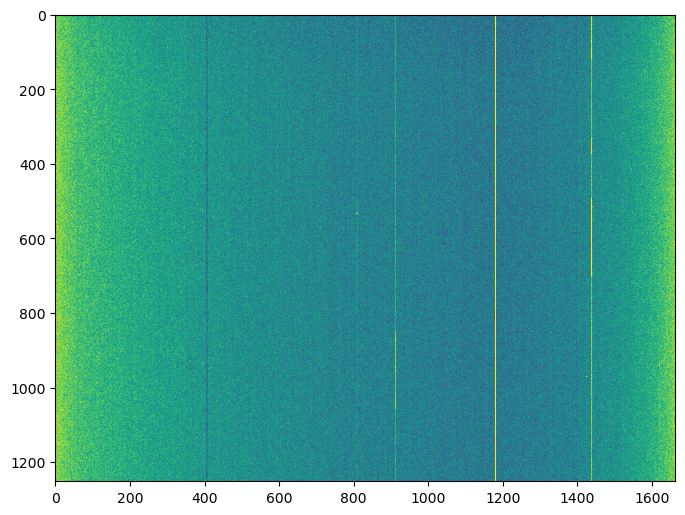

In [6]:
plot_img(bias_arr[4], hrange = 100)

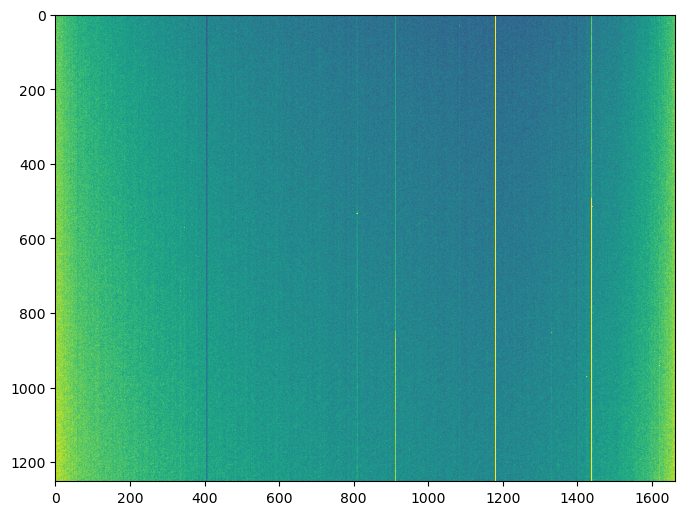

In [7]:
#%matplotlib widget
master_bias = np.median(bias_arr, axis = 0)

plot_img(master_bias, hrange = 100)

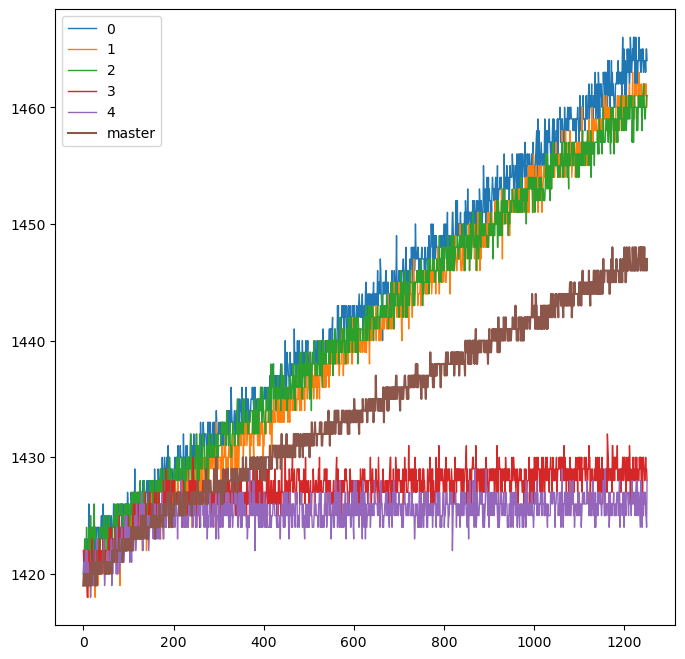

In [8]:
fig, ax = prep_plot()

for i, b in enumerate(bias_arr):
    bias_row_med = np.median(b, axis = 1)
    ax.plot(bias_row_med, linewidth = 1., label = i)

ax.plot(np.median(master_bias, axis = 1), label = 'master')
ax.legend()

# not great, not terrible...
# tbh, I have no idea why this is the case...

In [9]:
sub_mask_bias = np.s_[250:300, 250:300]

bias_std = np.mean([np.std(b[sub_mask_bias]) for b in bias_arr])

ron = bias_std*gain
print("%2.3f ph" % ron)

19.687 ph


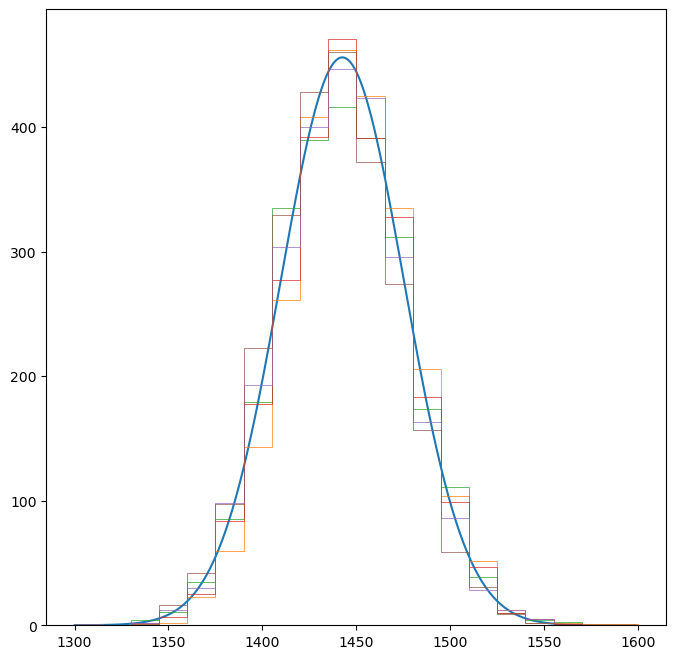

In [10]:
# do we like that value?
bias_mean = np.mean([np.mean(b[sub_mask_bias]) for b in bias_arr])
bias_max = np.mean([np.max(b[sub_mask_bias]) for b in bias_arr])

bins = 20

x = np.arange(1300, 1600)
bias_gauss = 1./(np.sqrt(2.*np.pi)*bias_std) * np.exp(-np.power((x-bias_mean)/bias_std, 2.)/2)
bias_gauss_norm = bias_gauss * len(bias_arr[0][sub_mask_bias].flatten()) * (300 / 20)

fig, ax = prep_plot()
ax.plot(x, bias_gauss_norm)
[ax.hist(b[sub_mask_bias].flatten(), bins=bins, histtype='step', linewidth = 0.5, range = [1300, 1600]) for b in bias_arr];

In [11]:
flat_arr_R_debias = np.array([flat_arr_R_i - master_bias for flat_arr_R_i in flat_arr_R])
flat_arr_B_debias = np.array([flat_arr_B_i - master_bias for flat_arr_B_i in flat_arr_B])

master_flat_R = np.median(flat_arr_R_debias, axis = 0)
master_flat_B = np.median(flat_arr_B_debias, axis = 0)

# normalize the flats
master_flat_R = master_flat_R / np.mean(master_flat_R)
master_flat_B = master_flat_B / np.mean(master_flat_B)

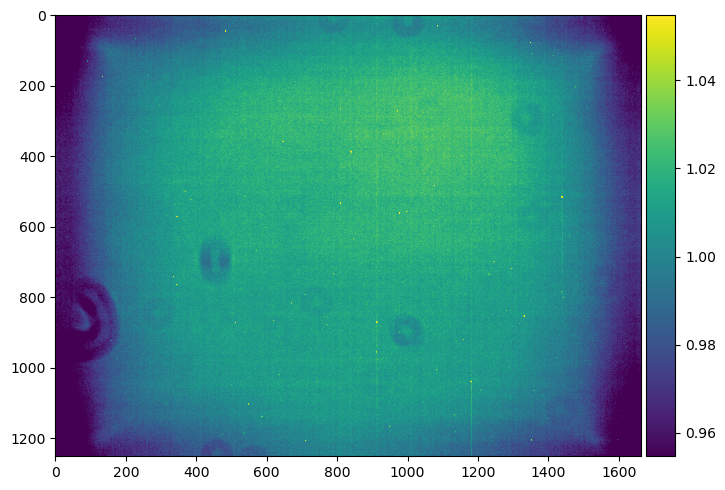

In [12]:
plot_img(master_flat_R, hrange = 0.05, colorbar = True)

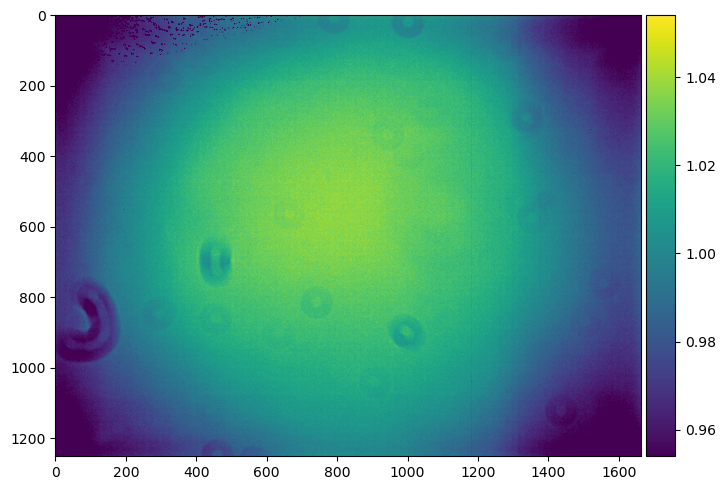

In [13]:
plot_img(master_flat_B, hrange = 0.05, colorbar = True)

In [14]:
# reduce all science frames
sci_red_R = [((sci_R_i - master_bias)/master_flat_R) for sci_R_i in sci_R];

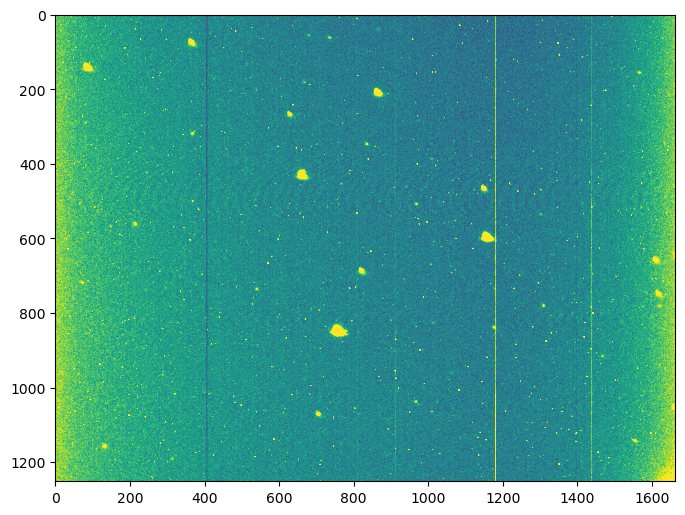

In [15]:
plot_img(sci_R[0], hrange = 100)

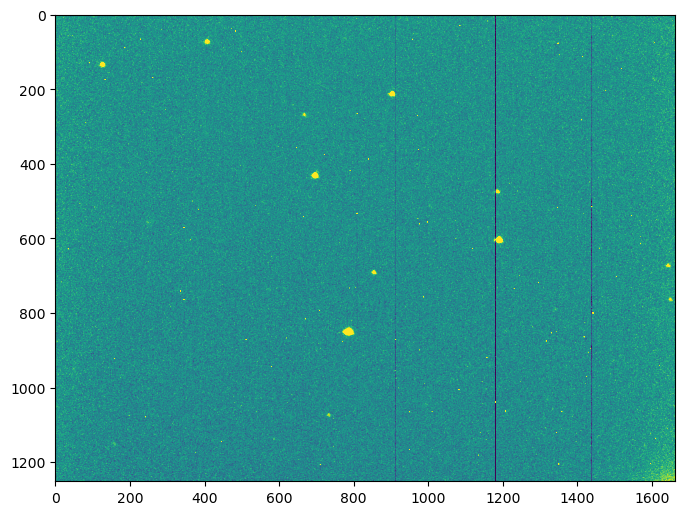

In [16]:
# plot the same frame as before
plot_img(sci_red_R[100], hrange = 100)

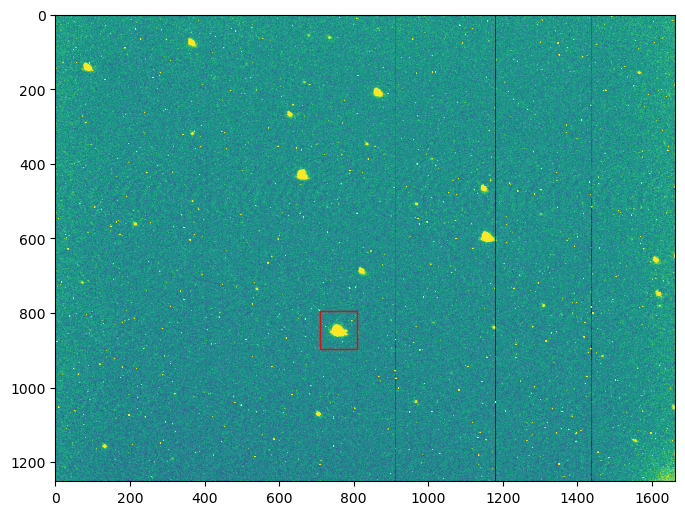

In [17]:
import matplotlib.patches as mpatches

fig, ax = prep_plot()

# add a rectangle
rect_size = np.array([100, 100])
rect = mpatches.Rectangle(get_2d_max(sci_red_R[0]) - rect_size//2, *rect_size, facecolor = 'none', edgecolor = 'red', lw = 1)

plot_img(sci_red_R[0], fig = fig, ax = ax, hrange = 100)
ax.add_patch(rect)

In [18]:
# sz_lyn region (note: the star unfortunately moves, this is large enough to keep it in the field at any time
np.s_[766:876, 719:819]

# ref star #1
np.s_[340:460, 620:760]

# ref star #2
np.s_[560:670, 1120:1225] # -> do not use this, bad line just on top of it (we do not like this at all)

(slice(560, 670, None), slice(1120, 1225, None))

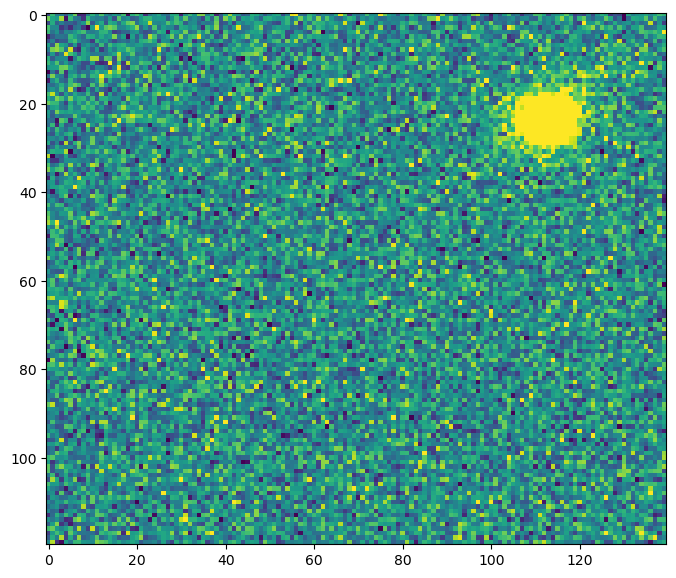

In [19]:
# get region around the star
y_max, x_max = get_2d_max(sci_red_R[0])
sub_mask_star = np.s_[340:460, 620:760] #np.s_[x_max - 80:x_max + 30, y_max - 40:y_max + 60]

star_region   = sci_red_R[-1][sub_mask_star]
plot_img(star_region, hrange = 100)
#plt.scatter(*get_2d_max(star_region))

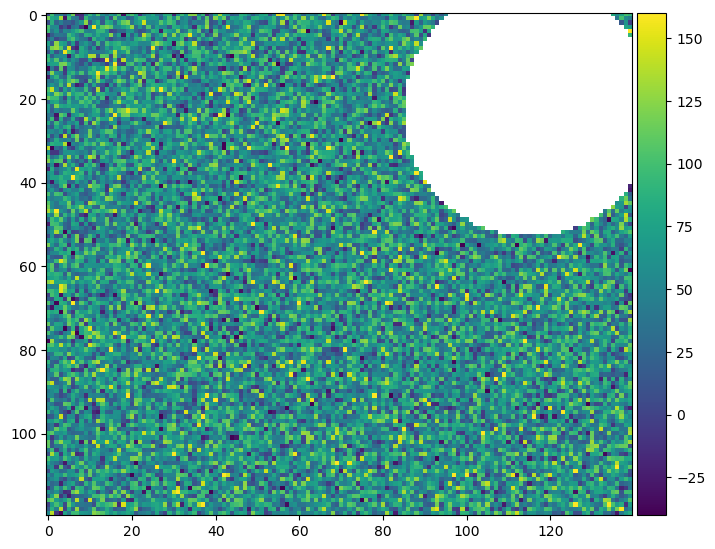

In [20]:
# get inside and outside part of the image
sub_sub_mask_star = mask_circ(star_region, radius = 30)

inside  = dc(star_region)
inside[~sub_sub_mask_star] = np.nan
outside = dc(star_region)
outside[sub_sub_mask_star] = np.nan

plot_img(outside, hrange = 100, colorbar = True)

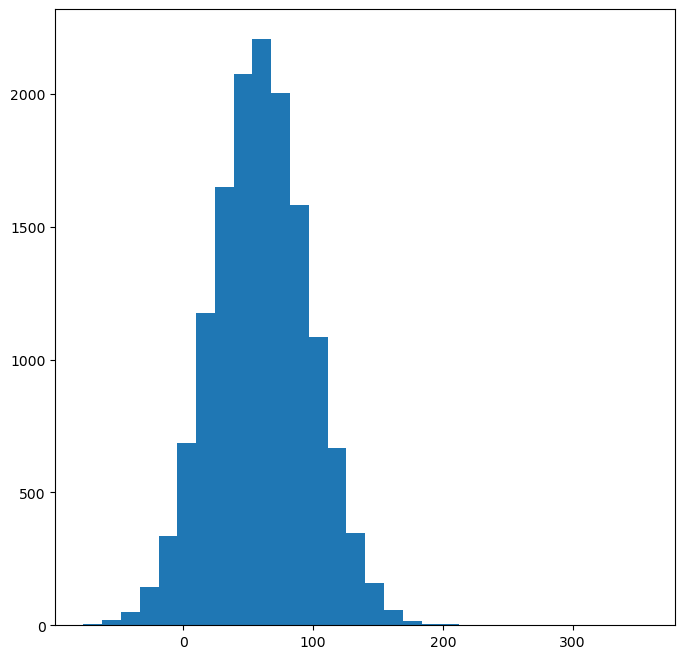

In [21]:
# get bkg
fig, ax = prep_plot()
ax.hist(safe(outside.flatten(), cutoff = 400), bins = 30);

In [22]:
outside_mean = np.nanmean(outside)
outside_std = np.nanstd(outside)

bkg = outside_mean*gain
bkg_noise = outside_std*gain
print("Background: %2.1f +/- %2.1f ph" % (bkg, bkg_noise))

Background: 36.3 +/- 25.0 ph


Peak: 6.05e+02, median: 5.61e+00


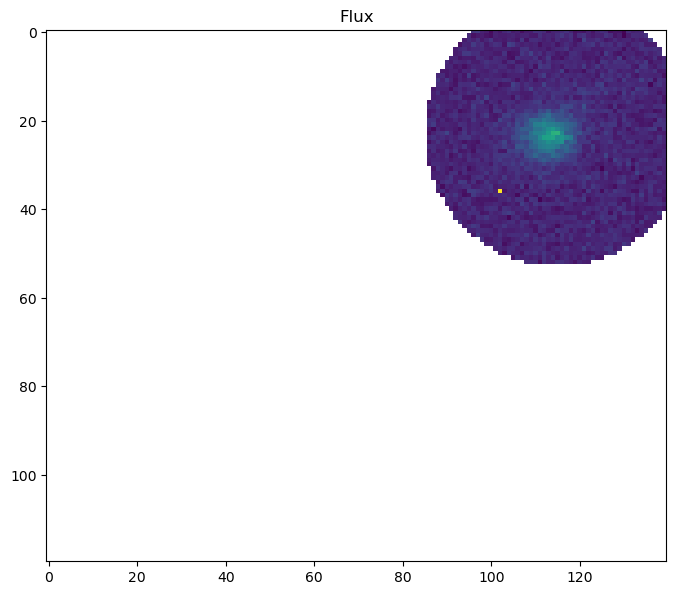

In [23]:
inside_bkgsub = inside - outside_mean

flux = inside_bkgsub * gain

plot_img(flux)
plt.title('Flux')

print("Peak: %2.2e, median: %2.2e" % (np.nanmax(flux), np.nanmedian(flux)))

Peak: 5.13e+01 ph, median: 4.51e+01 ph


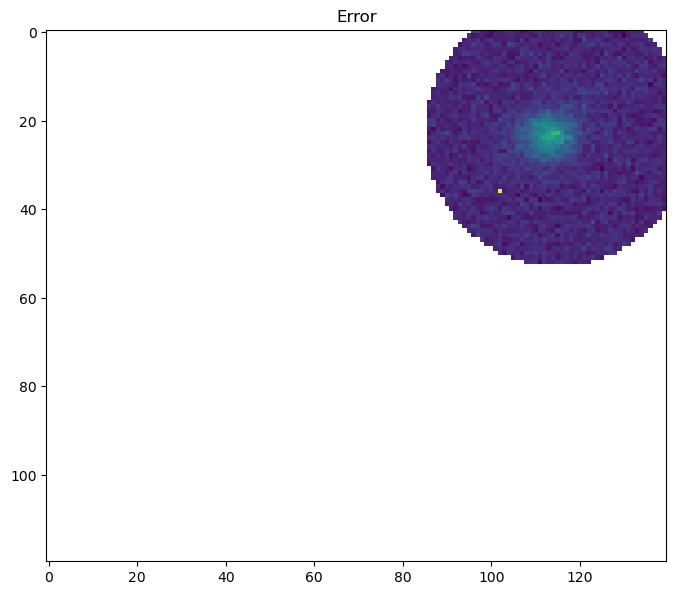

In [24]:
error = np.sqrt(flux + 2*ron**2 + 2*bkg_noise**2) # bit pessimistic, but better to be on the safe side!

plot_img(error)
plt.title('Error')
print("Peak: %2.2e ph, median: %2.2e ph" % (np.nanmax(error), np.nanmedian(error)))

In [25]:
# do everything together
# y_max, x_max = get_2d_max(sci_img)
# region = np.s_[x_max - mask_size:x_max + mask_size, y_max - mask_size:y_max + mask_size]
    
def photometry(sci_img, region, mask_size = 60, radius = 30, plot = False):
    star_region = sci_img[region]
    if plot:
        plot_img(star_region)
    
    sub_sub_mask_star = mask_circ(star_region, radius = radius)

    inside  = dc(star_region)
    inside[~sub_sub_mask_star] = np.nan
    outside = dc(star_region)
    outside[sub_sub_mask_star] = np.nan
    
    npix = np.sum(~np.isnan(inside))
    
    outside_mean = np.nanmean(outside)
    outside_std = np.nanstd(outside)

    bkg = outside_mean*gain
    bkg_noise = outside_std*gain
    
    inside_bkgsub = inside - outside_mean
    flux = np.nansum(inside_bkgsub * gain)
    err = np.sqrt(flux + 2 * (ron**2 + bkg_noise**2) * npix)
    
    return flux, err

In [26]:
fl_list_sz_lyn = []
fl_list_ref = []

mag_sz_lyn = []

def magnitude(flux, flux_ref, mag_ref):
    mag = mag_ref - 2.5*(np.log10(flux/flux_ref))
    return mag
    
for img in sci_red_R:
    flux_sz_lyn, err_sz_lyn = photometry(img, np.s_[766:876, 719:819])
    flux_ref, _ = photometry(img, np.s_[340:460, 620:760])
    fl_list_sz_lyn.append(flux_sz_lyn);
    fl_list_ref.append(flux_ref)
    mag_sz_lyn.append(magnitude(flux_sz_lyn, flux_ref, 11.222))
    
def magnitude(self, ref):
    self.mag = ref.mag - 2.5*(np.log10(self.flux)-np.log10(ref.flux))

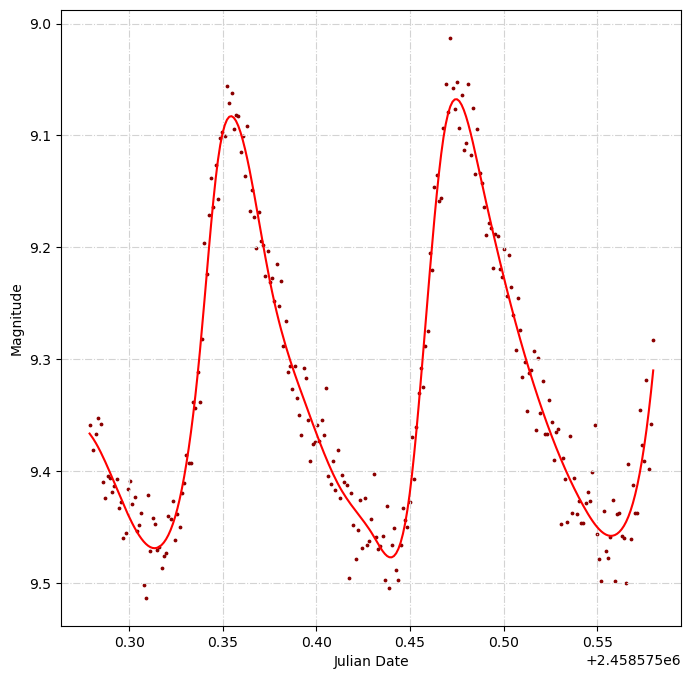

In [27]:
def get_jd_time(path):
    with fits.open(path) as f:
        return f[0].header['JD-HELIO']
    
jd_helio_list = np.array([get_jd_time('./SZ_Lyn/R/SZ_Lyn-{:04d}R.fit'.format(i)) for i in range(1, 251)])

fig, ax = prep_plot()

ax.scatter(jd_helio_list, mag_sz_lyn, s = 3, color = 'darkred')
ax.set_ylim(ax.get_ylim()[::-1]) # this just reverses the axis

ax.set_ylabel('Magnitude')
ax.set_xlabel('Julian Date')

ax.grid(color = 'lightgrey', ls = '-.')

# spline the data
from scipy.interpolate import UnivariateSpline as us

spl = us(jd_helio_list, mag_sz_lyn, s = 0.15)
ax.plot(jd_helio_list, spl(jd_helio_list), color = 'red')

In [28]:
# find position of the two peaks
before_min_one = jd_helio_list[jd_helio_list < 2458575.4305477603]
after_min_one  = jd_helio_list[jd_helio_list > 2458575.4305477603]

print(before_min_one[np.argmax(spl(before_min_one))])
print(after_min_one[np.argmax(spl(after_min_one))])
print(np.abs(2458575.313717402 - 2458575.4401765727))

# use this for conversion: https://ssd.jpl.nasa.gov/tools/jdc/#/jd
# does this make sense? can you find other measurements that support what got? is the magnitude measurement comparable to other values found in literature?

2458575.313717402
2458575.4401765727
0.12645917059853673
